# Predecir la promoción de un empleado



* Limpieza/preprocesamiento  
* Clases desbalanceadas
*   Keras-tuner




Dataset

https://www.kaggle.com/code/muhammadimran112233/employee-promotion-end-to-end-solution/input


incluir, al menos, lo siguiente


* Manejo de datos faltantes
* datos repetidos
* columnas constantes
* ¿hay outliers?
* ¿selección de atributos?
* estandarización de datos
* Manejo de datos desbalanceados
* Keras-tuner, usar conjunto de validación
  * construir modelo con los mejores parámetros
  * graficar loss y acc de train y validación
  * evaluar con X_test
  * obtener matriz de confusión

# Importando Dataset y Librerias

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv('./employee_promotion.csv')

# Análisis Exploratorio de datos

Tenemos las siguientes columnas

- **department**: Departamento del empleado  
- **region**: Región de empleo (no ordenada)  
- **education**: Nivel educativo  
- **gender**: Género del empleado  
- **recruitment_channel**: Canal de reclutamiento del empleado  
- **no_of_trainings**: Número de capacitaciones adicionales completadas el año anterior (habilidades blandas, técnicas, etc.)  
- **age**: Edad del empleado  
- **previous_year_rating**: Calificación del empleado en el año anterior  
- **length_of_service**: Antigüedad en años de servicio  
- **awards_won**: Si ganó premios el año anterior → 1, de lo contrario 0  
- **avg_training_score**: Puntaje promedio en evaluaciones de capacitaciones actuales  
- **is_promoted**: **(Variable objetivo)** Si fue recomendado para promoción  

Como vemos hay varios preguntas que tenemos que hacernos de primera mano, ¿Necesitamos el número de empleado?, ¿Tener el genero es necesario, habra un cesgo en los datos hacia los hombres para hacer las promociones?

In [3]:
df.shape

(54808, 13)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54808 entries, 0 to 54807
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   employee_id           54808 non-null  int64  
 1   department            54808 non-null  object 
 2   region                54808 non-null  object 
 3   education             52399 non-null  object 
 4   gender                54808 non-null  object 
 5   recruitment_channel   54808 non-null  object 
 6   no_of_trainings       54808 non-null  int64  
 7   age                   54808 non-null  int64  
 8   previous_year_rating  50684 non-null  float64
 9   length_of_service     54808 non-null  int64  
 10  awards_won            54808 non-null  int64  
 11  avg_training_score    52248 non-null  float64
 12  is_promoted           54808 non-null  int64  
dtypes: float64(2), int64(6), object(5)
memory usage: 5.4+ MB


Al parecer solo las columnas avg_training_score, education, previous_year_rating son las que tienen valores nulos, el porcentaje son minimo entonces tal vez sea buena idea imputarlas

In [5]:
df.describe()

,employee_id,no_of_trainings,age,previous_year_rating,length_of_service,awards_won,avg_training_score,is_promoted
count,54808.000000,54808.000000,54808.000000,50684.000000,54808.000000,54808.000000,52248.000000,54808.000000
mean,39195.830627,1.253011,34.803915,3.329256,5.865512,0.023172,63.712238,0.085170
std,22586.581449,0.609264,7.660169,1.259993,4.265094,0.150450,13.521910,0.279137
min,1.000000,1.000000,20.000000,1.000000,1.000000,0.000000,39.000000,0.000000
25%,19669.750000,1.000000,29.000000,3.000000,3.000000,0.000000,51.000000,0.000000
50%,39225.500000,1.000000,33.000000,3.000000,5.000000,0.000000,60.000000,0.000000
75%,58730.500000,1.000000,39.000000,4.000000,7.000000,0.000000,77.000000,0.000000
max,78298.000000,10.000000,60.000000,5.000000,37.000000,1.000000,99.000000,1.000000


In [6]:
df.head(10)

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,awards_won,avg_training_score,is_promoted
0,65438,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5.0,8,0,49.0,0
1,65141,Operations,region_22,Bachelor's,m,other,1,30,5.0,4,0,60.0,0
2,7513,Sales & Marketing,region_19,Bachelor's,m,sourcing,1,34,3.0,7,0,50.0,0
3,2542,Sales & Marketing,region_23,Bachelor's,m,other,2,39,1.0,10,0,50.0,0
4,48945,Technology,region_26,Bachelor's,m,other,1,45,3.0,2,0,73.0,0
5,58896,Analytics,region_2,Bachelor's,m,sourcing,2,31,3.0,7,0,85.0,0
6,20379,Operations,region_20,Bachelor's,f,other,1,31,3.0,5,0,59.0,0
7,16290,Operations,region_34,Master's & above,m,sourcing,1,33,3.0,6,0,63.0,0
8,73202,Analytics,region_20,Bachelor's,m,other,1,28,4.0,5,0,83.0,0
9,28911,Sales & Marketing,region_1,Master's & above,m,sourcing,1,32,5.0,5,0,54.0,0


Tenemos como columnas categóricas a:
- department
- region
- educacion
- genero
- recruiment_chanel
- awards_won

El resto son columnas numericas.

In [7]:
# Convertir todas las columnas object a category
for col in df.select_dtypes(include='object').columns:
    df[col] = df[col].astype('category')

# Convertir awards_won a category
df['awards_won'] = df['awards_won'].astype('category')

Vemos si hay filas repetidas

In [8]:
df.duplicated().sum()

np.int64(0)

Vamos a ver filas con valores nulos

In [9]:
df.isnull().sum() / df.shape[0] * 100

employee_id             0.000000
department              0.000000
region                  0.000000
education               4.395344
gender                  0.000000
recruitment_channel     0.000000
no_of_trainings         0.000000
age                     0.000000
previous_year_rating    7.524449
length_of_service       0.000000
awards_won              0.000000
avg_training_score      4.670851
is_promoted             0.000000
dtype: float64

Vamos a ver si hay sesgo al momento de promocionar a alguien por el genero.

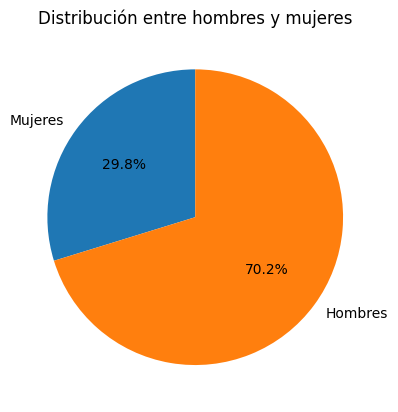

In [10]:
values_counts = df[['gender']].value_counts()
number_men = values_counts['m']
number_women = values_counts['f']

labels = ['Mujeres', 'Hombres']

plt.pie([number_women, number_men], labels=labels, autopct='%1.1f%%', startangle=90)
plt.title('Distribución entre hombres y mujeres')
plt.show()





Vemos que aproximadamente el 70% de las personas son hombres y 30% mujeres, vamos a ver si se conserva esta proporcion al momento de promocionar a alguien

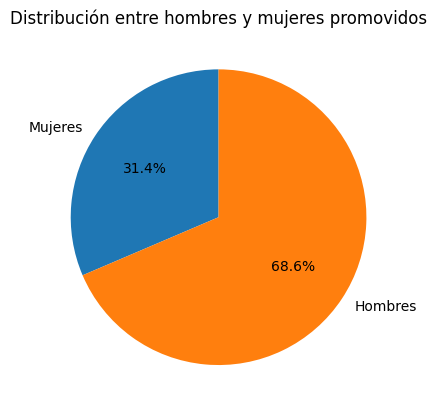

In [11]:
df_promoted = df[df['is_promoted'] == 1]
df_promoted.groupby('is_promoted')['gender'].value_counts()

number_men_promoted = len(df_promoted[df_promoted['gender'] == 'm'])
number_women_promoted = len(df_promoted[df_promoted['gender'] == 'f'])

labels = ['Mujeres', 'Hombres']

plt.pie([number_women_promoted, number_men_promoted], labels=labels, autopct='%1.1f%%', startangle=90)
plt.title('Distribución entre hombres y mujeres promovidos')
plt.show()

Vemos que no hay un sesgo al momento de promover a un empleado por su genero

Ahora vamos a ver la distribucion de nuestras variables

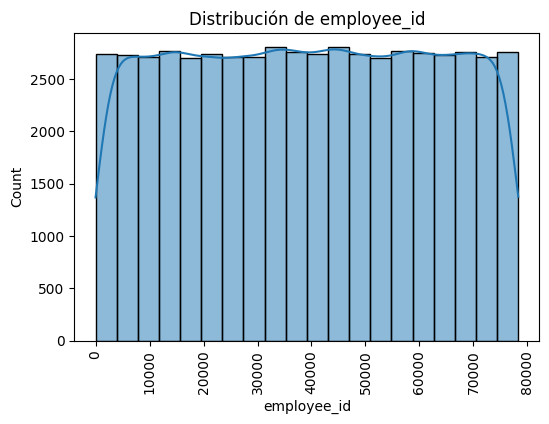

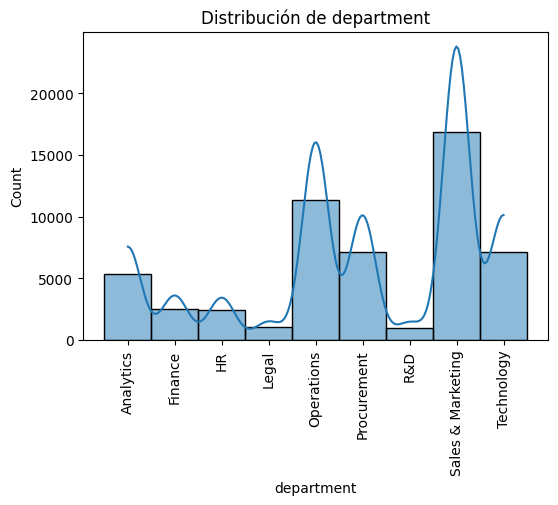

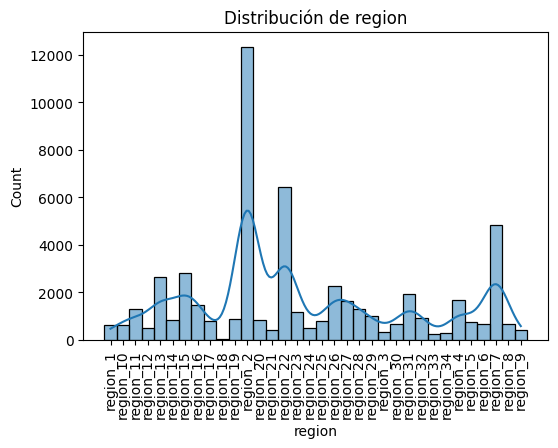

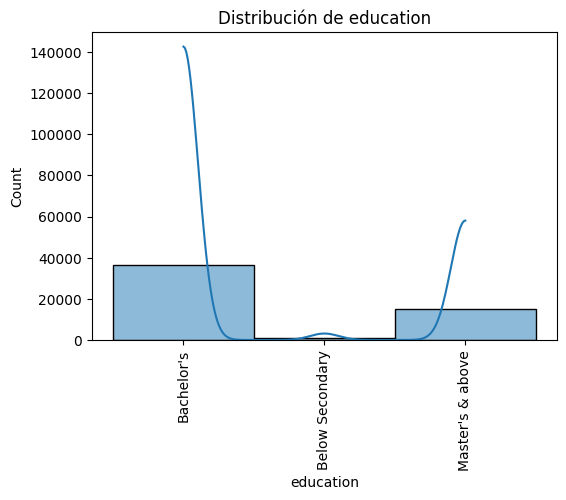

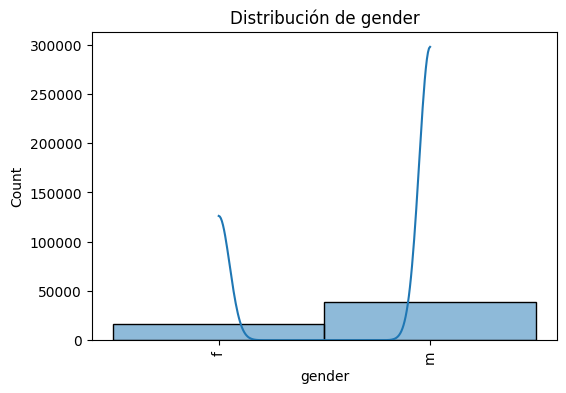

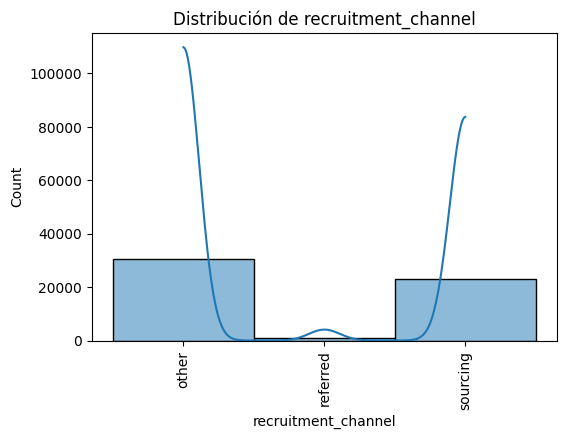

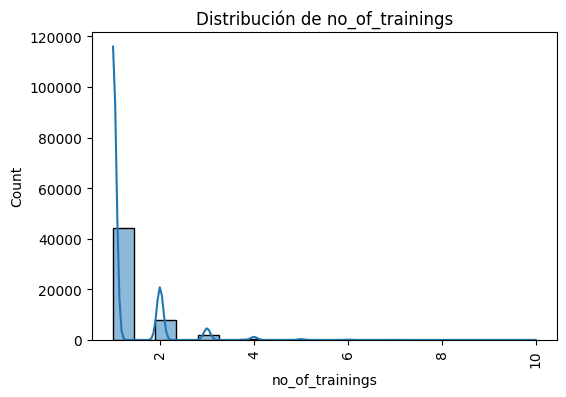

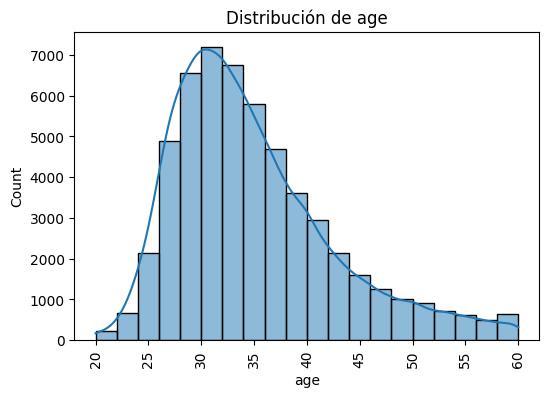

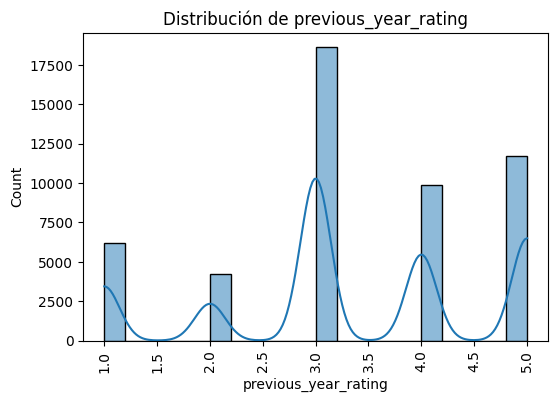

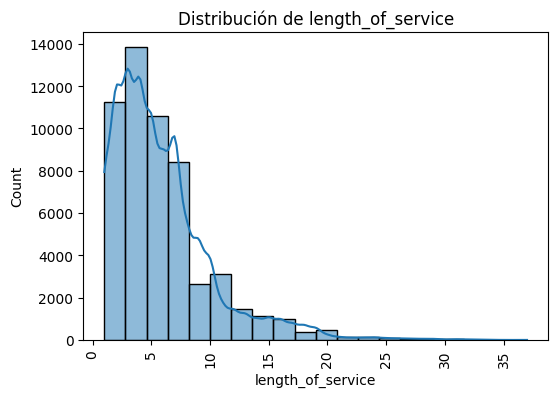

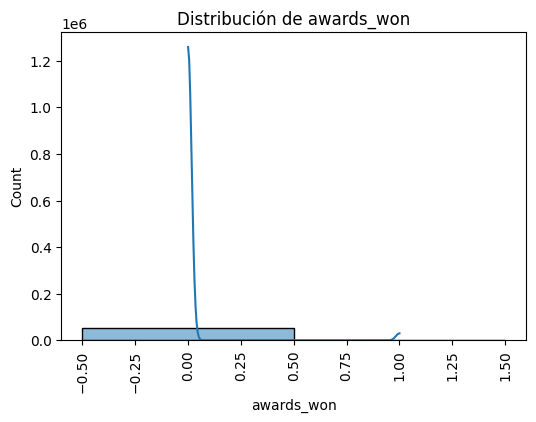

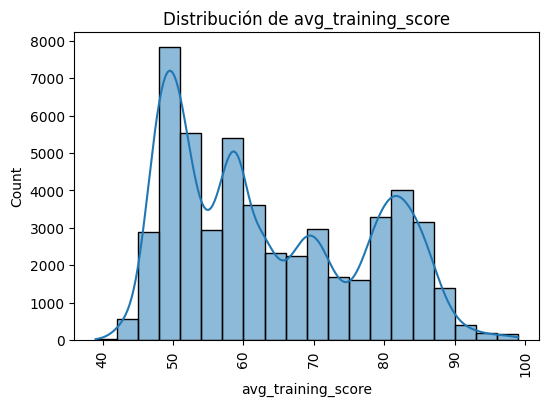

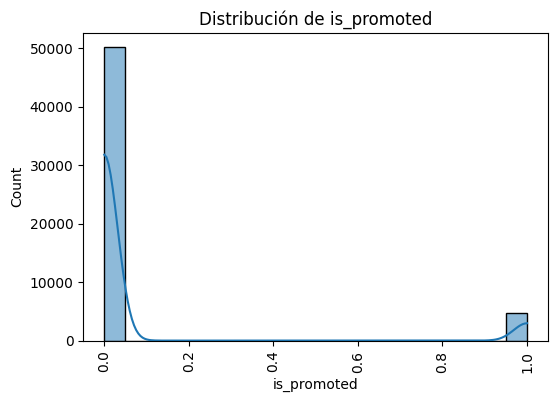

In [12]:
for col in df.columns:
    plt.figure(figsize=(6,4))
    if df[col].dtype == 'object':
        sns.countplot(data=df, x=col)
        plt.title(f"Distribución de {col}")
    else:  # numéricas
        sns.histplot(data=df, x=col, kde=True, bins=20)
        plt.title(f"Distribución de {col}")
    plt.xticks(rotation=90)
    plt.show()


Vemos que tenemos clases desbalanceadas, si nos fijamos en la variable "is_promoted"

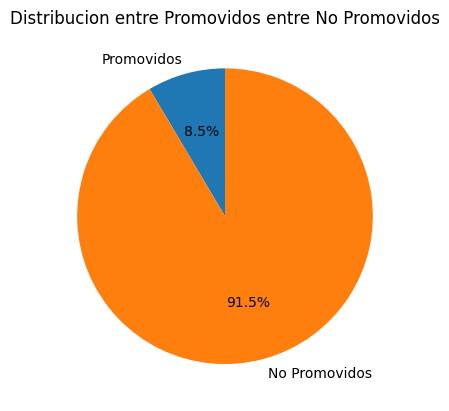

In [13]:
labels = ['Promovidos', 'No Promovidos']

promoted = len(df[df['is_promoted'] == 1])
no_promoted = df.shape[0] - promoted
plt.pie([promoted, no_promoted], labels=labels, autopct='%1.1f%%', startangle=90)
plt.title('Distribucion entre Promovidos entre No Promovidos')
plt.show()

Ahora vamos a ver nuestros datos con respecto a nuestra variable objetiva

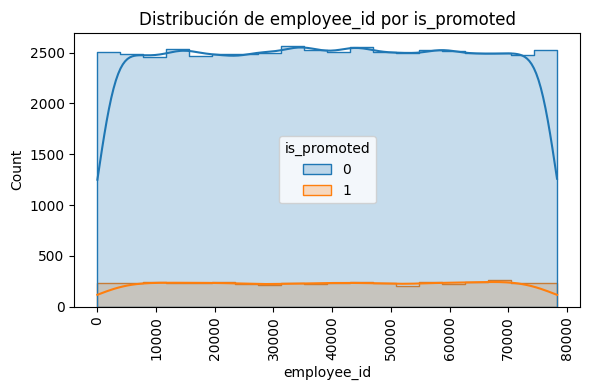

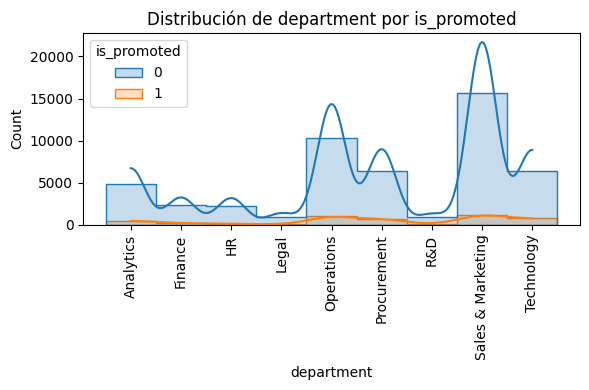

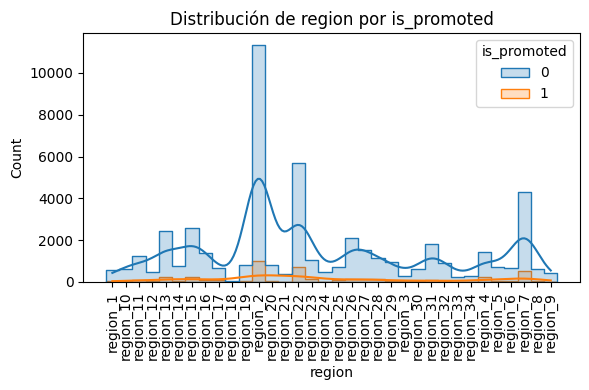

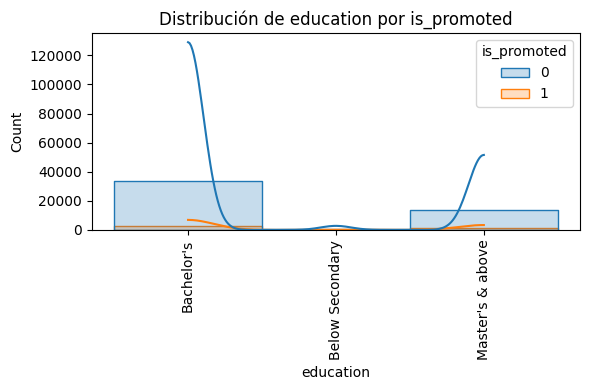

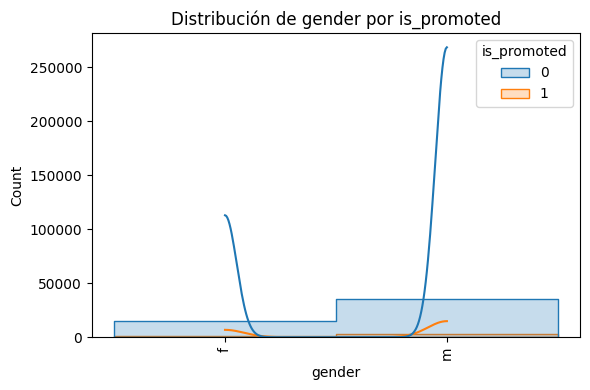

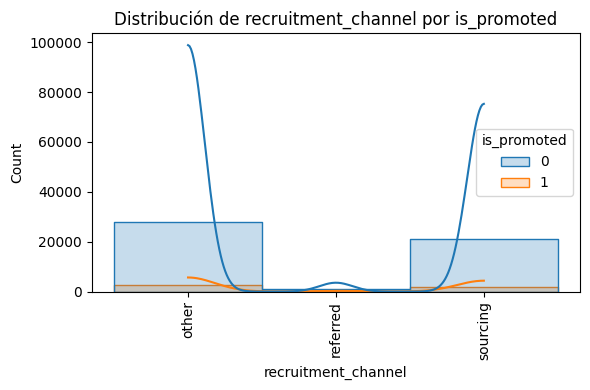

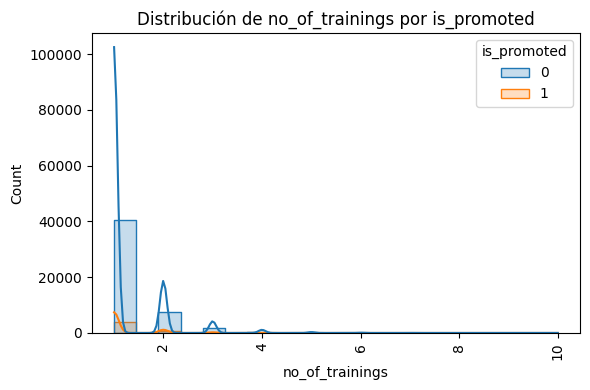

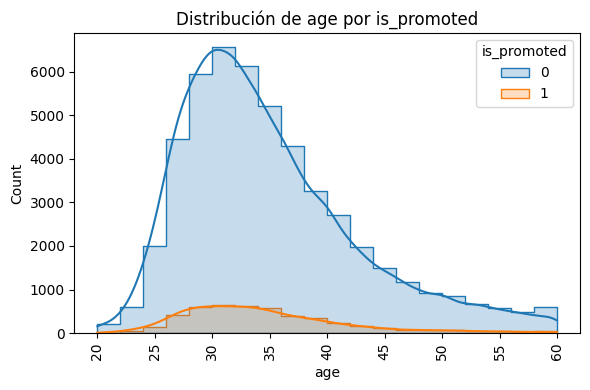

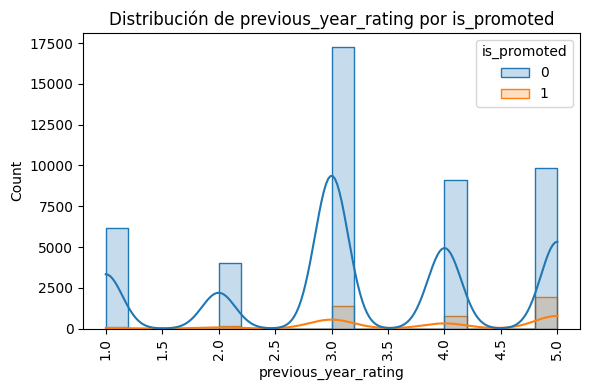

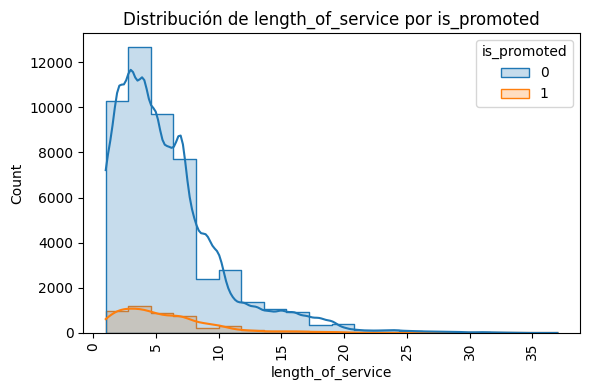

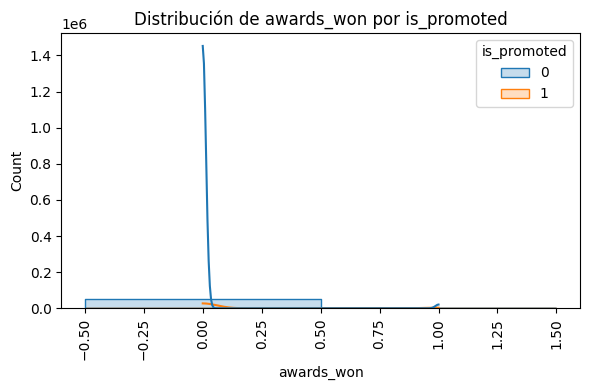

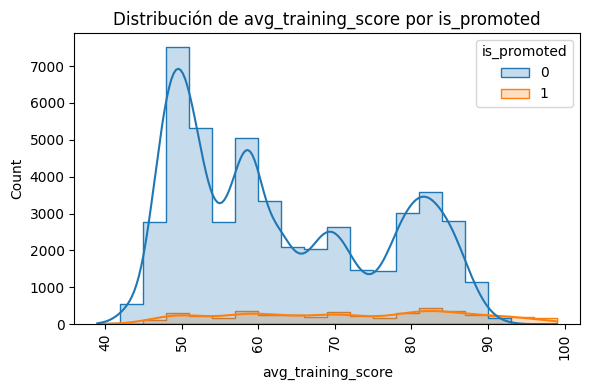

In [14]:
target = "is_promoted"

for col in df.columns:
    if col == target:
        continue

    plt.figure(figsize=(6,4))

    if df[col].dtype == 'object':
        sns.countplot(data=df, x=col, hue=target)
        plt.title(f"Distribución de {col} por {target}")
    else:  # numéricas
        sns.histplot(data=df, x=col, hue=target, kde=True, bins=20, element="step")
        plt.title(f"Distribución de {col} por {target}")

    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()


Al parecer todas las variables tienen relación, lo único que quitaremos por el momento es el número de empleado que no nos sirve de nada para el modelo.

In [15]:
df.drop('employee_id', axis=1, inplace=True)

Vamos a ver que columnas tienen outliers

In [16]:
numeric_cols = list(df.select_dtypes(include="number"))
numeric_cols.remove("is_promoted")

prop_outliers = {}
for c in numeric_cols:
  q1 = df[c].dropna().quantile(.25)
  q3 = df[c].dropna().quantile(.75)
  IQR = q3 - q1

  lower = q1 - 1.5*IQR
  high = q3 + 1.5*IQR

  prop_outliers[c] = df[(df[c] < lower) | (df[c] > high)].shape[0] / df.shape[0] * 100

for k,v in prop_outliers.items():
  print(f"La columna {k} tiene {v}% de outliers")


La columna no_of_trainings tiene 19.03006860312363% de outliers
La columna age tiene 2.618230915194862% de outliers
La columna previous_year_rating tiene 11.354181871259671% de outliers
La columna length_of_service tiene 6.365858998686323% de outliers
La columna avg_training_score tiene 0.0% de outliers


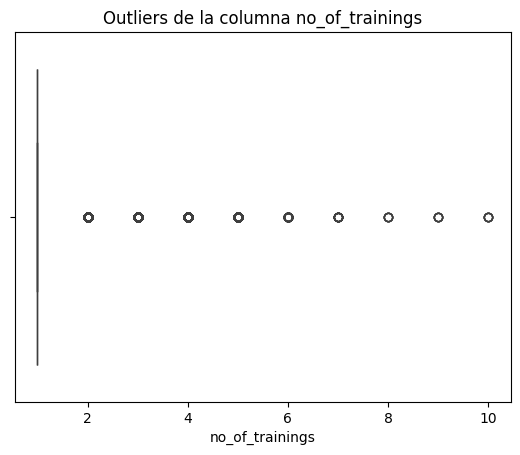

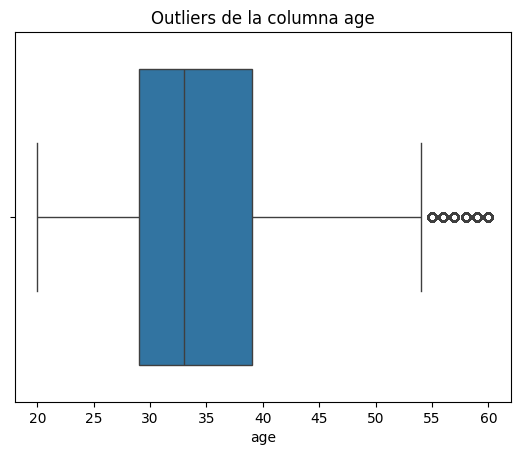

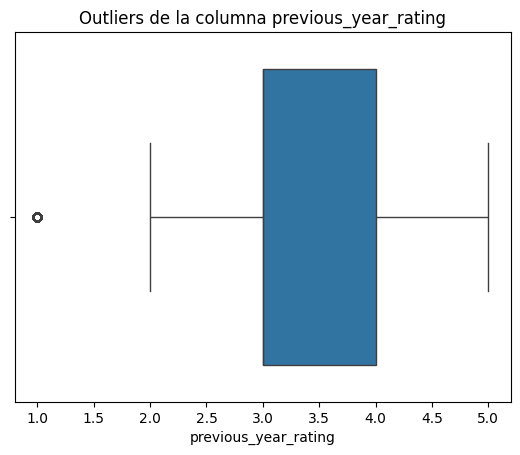

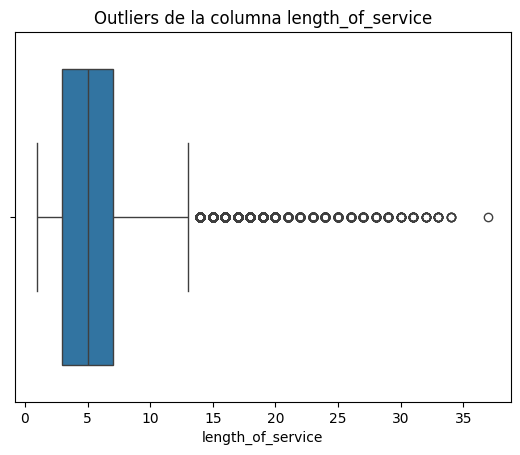

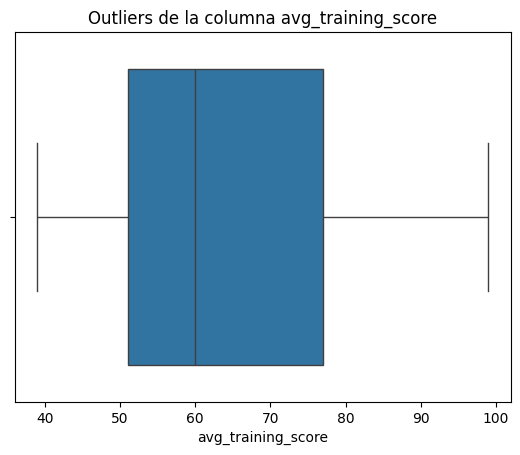

In [17]:
for c in numeric_cols:
  sns.boxplot(data=df, x=c)
  plt.title(f"Outliers de la columna {c}")
  plt.show()

Vemos que si hay outliers, pero no son por errores de medición, ahora vamos a ver si hay sesgo.

In [18]:
skews = {}
for c in numeric_cols:
  skews[c] = df[c].skew()

for k,v in skews.items():
  print(f"la columna {k} tiene un sesgo de {v}")

la columna no_of_trainings tiene un sesgo de 3.445433937567454
la columna age tiene un sesgo de 1.0074317710382241
la columna previous_year_rating tiene un sesgo de -0.3106378431385327
la columna length_of_service tiene un sesgo de 1.738061458740809
la columna avg_training_score tiene un sesgo de 0.4191534330632933


Vemos que son algunas columnas las que tienen  sesgo, entonces tambien hay que corregirlo.

## Dividiendo el dataset

In [19]:
X = df.drop('is_promoted', axis=1)
y = df[['is_promoted']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, stratify=y_train, random_state=42)

## Preprocesamiento de Datos

### Imputando datos

Vamos a imputar los datos de las columnas avg_training_score, education, previous_year_rating que eran las que tenian valores faltantes.

In [20]:

median = X_train['previous_year_rating'].median()
X_train['previous_year_rating'].fillna(median, inplace=True)
X_test['previous_year_rating'].fillna(median, inplace=True)
X_test['previous_year_rating'].fillna(median, inplace=True)

mean = X_train['avg_training_score'].mean()
X_train['avg_training_score'].fillna(mean, inplace=True)
X_test['avg_training_score'].fillna(mean, inplace=True)
X_val['avg_training_score'].fillna(mean, inplace=True)

mode = X_train['education'].mode()[0]
X_train['education'].fillna(mode, inplace=True)
X_test['education'].fillna(mode, inplace=True)
X_val['education'].fillna(mode, inplace=True)

/tmp/ipykernel_1621785/3393944138.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_train['previous_year_rating'].fillna(median, inplace=True)
/tmp/ipykernel_1621785/3393944138.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, in

Vamos a ver si podemos eliminar columnas que no nos sean tan utiles. Vamos a ver por correlaciones en columnas.

In [21]:
# Correlaciones con el target

Xy_train = pd.concat([X_train, y_train], axis=1)
Xy_train_num = Xy_train.select_dtypes(include="number")

corrs = Xy_train_num.corr(method="pearson")["is_promoted"].sort_values(ascending=False)

print(corrs)

is_promoted             1.000000
avg_training_score      0.181495
previous_year_rating    0.153849
length_of_service      -0.012608
age                    -0.021045
no_of_trainings        -0.025986
Name: is_promoted, dtype: float64


Vemos que no cambia mucho las variables relacionadas con los que estan promovidos

Las que mas tienen correlacion con el target son avg_training_score y previous_year_rating. Nota: esto es después de haber entrenado dejando solo las columnas anteriores: vamos a incluir años de servicio.

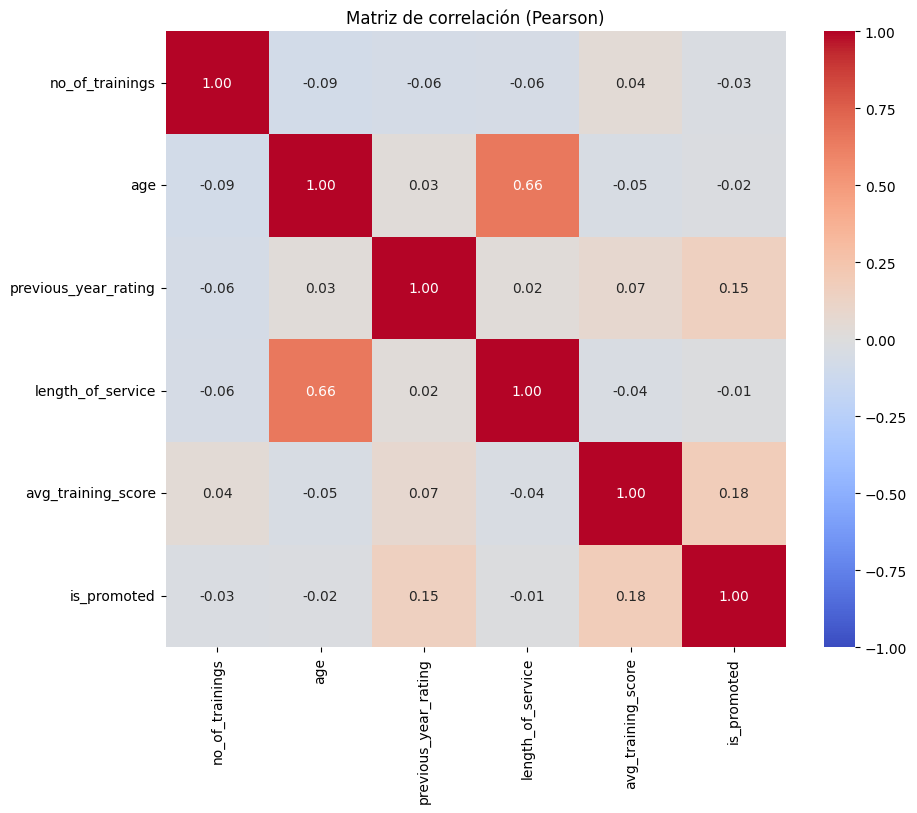

In [22]:
corr_matrix = Xy_train_num.corr(method="pearson")

plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Matriz de correlación (Pearson)")
plt.show()

Vamos a ver si generando nuevas columnas ayuda

In [23]:
# 2. Crear nuevas columnas en train
Xy_train["training_x_rating"] = Xy_train["avg_training_score"] * Xy_train["previous_year_rating"]
Xy_train["training_x_service"] = Xy_train["avg_training_score"] * Xy_train["length_of_service"]
Xy_train["rating_x_service"] = Xy_train["previous_year_rating"] * Xy_train["length_of_service"]

Xy_train["training_per_service"] = Xy_train["avg_training_score"] / (Xy_train["length_of_service"] + 1)
Xy_train["training_per_age"] = Xy_train["avg_training_score"] / (Xy_train["age"] + 1)

Xy_train["training_sq"] = Xy_train["avg_training_score"] ** 2
Xy_train["service_sq"] = Xy_train["length_of_service"] ** 2
Xy_train["rating_sq"] = Xy_train["previous_year_rating"] ** 2

# 3. Calcular correlaciones (solo numéricas)
Xy_train_num = Xy_train.select_dtypes(include="number")

corrs = Xy_train_num.corr(method="pearson")["is_promoted"].sort_values(ascending=False)

print("📊 Correlaciones con 'is_promoted' (todas las columnas numéricas, incluidas las nuevas):\n")
print(corrs)

📊 Correlaciones con 'is_promoted' (todas las columnas numéricas, incluidas las nuevas):

is_promoted             1.000000
training_x_rating       0.229712
training_sq             0.190345
avg_training_score      0.181495
rating_sq               0.157247
previous_year_rating    0.153849
training_per_age        0.140622
training_per_service    0.068759
rating_x_service        0.054729
training_x_service      0.036461
length_of_service      -0.012608
service_sq             -0.012767
age                    -0.021045
no_of_trainings        -0.025986
Name: is_promoted, dtype: float64


Vamos a quedarnos con training_s_rating y training_sq para ver si esto ayuda a nuestro modelo

In [24]:
for X in [X_train, X_test, X_val]:
    X["training_x_rating"] = X["avg_training_score"] * X["previous_year_rating"]
    X["training_sq"] = X["avg_training_score"] ** 2

In [25]:
from scipy.stats import chi2_contingency

def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    return np.sqrt(phi2 / min(k-1, r-1))

X_cat = X_train.select_dtypes(include='category')  

for col in X_cat.columns:
    v = cramers_v(X_cat[col], y['is_promoted'])
    print(f"Cramér's V ({col} vs is_promoted): {v:.4f}")

Cramér's V (department vs is_promoted): 0.0497
Cramér's V (region vs is_promoted): 0.0936
Cramér's V (education vs is_promoted): 0.0271
Cramér's V (gender vs is_promoted): 0.0104
Cramér's V (recruitment_channel vs is_promoted): 0.0203
Cramér's V (awards_won vs is_promoted): 0.1886


Vemos que la única que tiene relacion con el target es awars_won, vamos a deshacernos de las demás.

In [26]:
to_drop = list(X_cat.columns)
to_drop.remove("awards_won")

for df in [X_train, X_val, X_test]:
    df.drop(to_drop, axis=1, inplace=True)

Las unicas de las varibales numéricas que vamos a conservar es avg_training_score y previous_year_rating que son las que mas relacion tienen con la variable objetivo. Tambien dejaremos length_of_service

In [27]:
keep_cols = ["avg_training_score", "previous_year_rating", "training_x_rating", "training_sq"]

num_cols = X_train.select_dtypes(include='number').columns

to_drop = [c for c in num_cols if c not in keep_cols]

for df in [X_train, X_val, X_test]:
    df.drop(to_drop, axis=1, inplace=True)

In [28]:
X_train.shape

(39461, 5)

### Tratando Outliers

Vimos que es poco probable que los outliers se deban a errores, haremos winsorizacion.

In [29]:
columns_with_outliers = [
    "previous_year_rating",
]

for c in columns_with_outliers:
    lower = X_train[c].quantile(0.01)
    upper = X_train[c].quantile(0.99)
    X_train[c + "_wins"] = X_train[c].clip(lower, upper)
    X_test[c + "_wins"] = X_test[c].clip(lower, upper)
    X_val[c + "_wins"] = X_val[c].clip(lower, upper)


Veamos si se conserva el sesgo en nuestras variables

In [30]:
skews = {}
for c in X_train.select_dtypes(include='number').columns:
  skews[c] = X_train[c].skew()

for k,v in skews.items():
  print(f"la columna {k} tiene un sesgo de {v}")

la columna previous_year_rating tiene un sesgo de -0.2624439382826854
la columna avg_training_score tiene un sesgo de 0.4308494071522068
la columna training_x_rating tiene un sesgo de 0.2821061373367504
la columna training_sq tiene un sesgo de 0.6625615330733731
la columna previous_year_rating_wins tiene un sesgo de -0.2624439382826854


Vemos que hay sesgo en las columnas relacionadas con length_of_service, vamos a usar coxbox, ya sabemos que no tiene valores en cero.

In [31]:
# from sklearn.preprocessing import PowerTransformer

# box_cox_columns = ['length_of_service_wins', 'length_of_service']
# transformed = ['length_of_service_wins_boxcox', 'length_of_service_boxcox']
# for c in box_cox_columns:
#     pt = PowerTransformer(method='box-cox')
#     X_train[f"{c}_boxcox"] = pt.fit_transform(X_train[[c]])
#     X_val[f"{c}_boxcox"] = pt.transform(X_val[[c]])
#     X_test[f"{c}_boxcox"] = pt.transform(X_test[[c]])

# X_train[transformed].skew()

ya no hay sesgo.

### Escalando las variables numéricas

In [32]:
from sklearn.preprocessing import StandardScaler, RobustScaler

numerical_cols = list(X_train.select_dtypes(include='number'))

for c in numerical_cols:
  ss = StandardScaler()
  X_train[c + "_ss"] = ss.fit_transform(X_train[[c]])
  X_test[c + "_ss"] = ss.transform(X_test[[c]])
  X_val[c + "_ss"] = ss.transform(X_val[[c]])

Nuestra unica variable categorica es la de si gano un premio el año pasado y ya esta codificada desde el principio, solo vamos a cambiarle el tipo a numerico

In [33]:
for X in [X_train, X_test, X_val]:
    X['awards_won'] = X['awards_won'].astype('int')

In [34]:
X_train.columns

Index(['previous_year_rating', 'awards_won', 'avg_training_score',
       'training_x_rating', 'training_sq', 'previous_year_rating_wins',
       'previous_year_rating_ss', 'avg_training_score_ss',
       'training_x_rating_ss', 'training_sq_ss',
       'previous_year_rating_wins_ss'],
      dtype='object')

In [35]:
cols_finales = [c for c in X_train.columns if c.endswith('_ss') or c.startswith('awards_won')]

print(sorted(cols_finales))

['avg_training_score_ss', 'awards_won', 'previous_year_rating_ss', 'previous_year_rating_wins_ss', 'training_sq_ss', 'training_x_rating_ss']


In [36]:
# Dataset final
X_train_final = X_train[cols_finales]
X_val_final = X_val[cols_finales]
X_test_final = X_test[cols_finales]


X_train_final.columns

Index(['awards_won', 'previous_year_rating_ss', 'avg_training_score_ss',
       'training_x_rating_ss', 'training_sq_ss',
       'previous_year_rating_wins_ss'],
      dtype='object')

In [37]:
X_train_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 39461 entries, 1539 to 37798
Data columns (total 6 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   awards_won                    39461 non-null  int64  
 1   previous_year_rating_ss       39461 non-null  float64
 2   avg_training_score_ss         39461 non-null  float64
 3   training_x_rating_ss          39461 non-null  float64
 4   training_sq_ss                39461 non-null  float64
 5   previous_year_rating_wins_ss  39461 non-null  float64
dtypes: float64(5), int64(1)
memory usage: 3.1 MB


In [38]:
y_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 39461 entries, 1539 to 37798
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   is_promoted  39461 non-null  int64
dtypes: int64(1)
memory usage: 616.6 KB


Ejecutando t-SNE...
t-SNE finalizado.


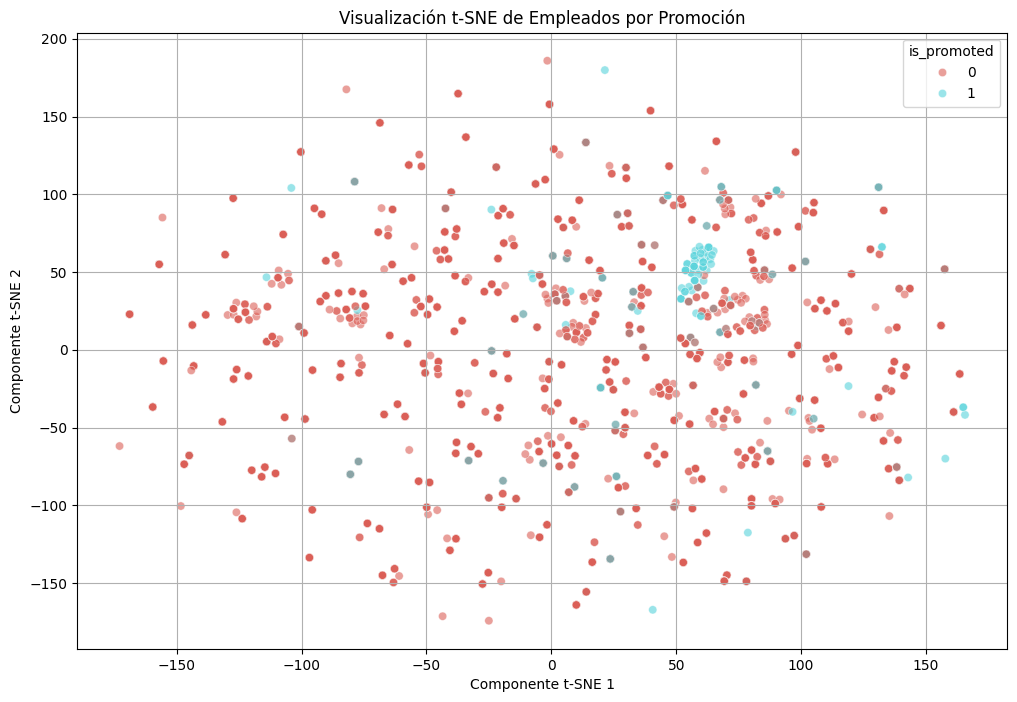

In [39]:
from sklearn.manifold import TSNE

sample_size = 5000
idx = np.random.choice(X_train.shape[0], sample_size, replace=False)

X_sample = X_train.iloc[idx]
y_sample = y_train.iloc[idx]


print("Ejecutando t-SNE...")
tsne = TSNE(
    n_components=2,        # Queremos un gráfico 2D
    perplexity=30,         # Un buen valor para empezar (prueba entre 5 y 50)
    max_iter=1000,           # Número de iteraciones
    learning_rate='auto',
    random_state=42,       # Para resultados reproducibles
    n_jobs=-1              # Usar todos los procesadores
)

tsne_results = tsne.fit_transform(X_sample)
print("t-SNE finalizado.")

# 3. Crear un DataFrame con los resultados para graficar
df_tsne = pd.DataFrame(tsne_results, columns=['tsne_1', 'tsne_2'])
df_tsne['is_promoted'] = y_sample.values

# 4. Graficar los resultados
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x='tsne_1', y='tsne_2',
    hue='is_promoted',
    palette=sns.color_palette("hls", 2),
    data=df_tsne,
    legend="full",
    alpha=0.6
)
plt.title('Visualización t-SNE de Empleados por Promoción')
plt.xlabel('Componente t-SNE 1')
plt.ylabel('Componente t-SNE 2')
plt.grid(True)
plt.show()

### OverSampling

Como tenemos clases desbalanceadas tenemos que corregir esto.

#### SMOTE

In [40]:
# Antes de Smote

y_train.value_counts()

is_promoted
0              36100
1               3361
Name: count, dtype: int64

In [41]:
from imblearn.combine import SMOTEENN

smote_enn = SMOTEENN(random_state=42, n_jobs=-1)
X_SMOTE, y_SMOTE = smote_enn.fit_resample(X_train_final, y_train)

In [42]:
# Despues de SMOTE
y_SMOTE.value_counts()

is_promoted
0              27813
1               6096
Name: count, dtype: int64

### Under Sampling

#### ClusterCentroids

In [43]:
# Antes de Under Sampling

y_train.value_counts()

is_promoted
0              36100
1               3361
Name: count, dtype: int64

In [44]:
from imblearn.under_sampling import ClusterCentroids
ncr = ClusterCentroids()
X_CC, y_CC = ncr.fit_resample(X_train_final, y_train)

/home/lcc_rn_08/.conda/envs/ml_gpu/lib/python3.10/site-packages/sklearn/base.py:1365: ConvergenceWarning: Number of distinct clusters (440) found smaller than n_clusters (3361). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


In [45]:
y_CC.value_counts()

is_promoted
0              3361
1              3361
Name: count, dtype: int64

## Modelo

A continuacion crearemos la plantilla de nuestro modelo

In [46]:
!pip install -q keras-tuner --upgrade

In [47]:
from keras.models import Model
from keras.layers import Dense, Input, Dropout
import keras_tuner as kt

import keras
from tensorflow.keras import regularizers
import tensorflow as tf

from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_f1_metric', 
    patience=5,               
    mode='max',              
    restore_best_weights=True 
)

def binary_focal_loss(alpha=0.25, gamma=2.0):
    eps = 1e-7
    def loss(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.clip_by_value(y_pred, eps, 1.0 - eps)
        p_t = tf.where(tf.equal(y_true, 1), y_pred, 1 - y_pred)
        alpha_t = tf.where(tf.equal(y_true, 1), alpha, 1 - alpha)
        loss = - alpha_t * tf.pow(1.0 - p_t, gamma) * tf.math.log(p_t)
        return tf.reduce_mean(loss)
    return loss
 

def f1_metric(y_true, y_pred):
    y_pred = tf.cast(y_pred > 0.5, tf.float32) # Viendo si modificando el threshold mejora
    y_true = tf.cast(y_true, tf.float32)
    tp = tf.reduce_sum(y_true * y_pred)
    fp = tf.reduce_sum((1 - y_true) * y_pred)
    fn = tf.reduce_sum(y_true * (1 - y_pred))
    precision = tp / (tp + fp + tf.keras.backend.epsilon())
    recall = tp / (tp + fn + tf.keras.backend.epsilon())
    return 2 * precision * recall / (precision + recall + tf.keras.backend.epsilon())

f1_metric_tf = tf.keras.metrics.MeanMetricWrapper(f1_metric, name="f1_metric")

num_features = X_SMOTE.shape[1]

def build_model(hp):
    inputs = Input(shape=(num_features,))
    x = inputs

    for i in range(2):
        units = hp.Int(f"units_layer_{i+1}", min_value=16, max_value=128, step=16)
        l2_reg = hp.Float(f"l2_layer_{i+1}", 1e-5, 1e-2, sampling="log")
        x = Dense(
            units=units,
            activation="relu",
            kernel_regularizer=regularizers.l2(l2_reg)
        )(x)
        dropout_rate = hp.Float(f"dropout_layer_{i+1}", 0.1, 0.5, step=0.1)
        x = Dropout(dropout_rate)(x)

    # Capa de salida para clasificación binaria
    outputs = Dense(1, activation="sigmoid")(x)
    model = Model(inputs=inputs, outputs=outputs)

    # Optimizador y learning rate como hiperparámetros
    lr = hp.Float("lr", 1e-4, 1e-2, sampling="log")
    optimizer_name = hp.Choice("optimizer", ["adam", "rmsprop"])
    if optimizer_name == "adam":
        optimizer = keras.optimizers.Adam(learning_rate=lr)
    elif optimizer_name == "rmsprop":
        optimizer = keras.optimizers.RMSprop(learning_rate=lr)

    model.compile(
        optimizer=optimizer,
        loss="binary_crossentropy",
        metrics=[
            tf.keras.metrics.AUC(curve='PR', name='pr_auc'),
            f1_metric_tf,
            keras.metrics.Precision(name="precision"),
            keras.metrics.Recall(name="recall"),
            "accuracy"
        ]
    )

    return model



2025-09-26 18:02:32.467067: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-26 18:02:33.304036: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [48]:
from sklearn.utils import class_weight
import keras_tuner as kt

def train_model(
    X, y, 
    X_val, y_val, 
    use_class_weights=False, 
    batch_size=64, 
    max_epochs=30,
    project_name='CC',
    metric='val_f1_metric'
):
    # Calcular pesos si se requiere
    class_weights = None
    if use_class_weights:
        y_array = np.ravel(y)
        weights = class_weight.compute_class_weight(
            class_weight='balanced',
            classes=np.unique(y_array),
            y=y_array
        )
        class_weights = dict(enumerate(weights))
        print(f"Usando pesos de clase: {class_weights}")

    # Configurar tuner
    tuner = kt.Hyperband(
        build_model,
        objective=kt.Objective(metric, "max"),
        executions_per_trial=1,
        max_epochs=max_epochs,
        factor=3,
        directory='output',
        project_name=project_name,
        overwrite=True
    )

    tuner.search_space_summary()
    print("\n--- Iniciando búsqueda con Hyperband ---")

    # Incluir class_weights solo si se usan
    tuner.search(
        X,
        y,
        validation_data=(X_val, y_val),
        batch_size=batch_size,
        class_weight=class_weights,
        callbacks=[early_stopping]
    )

    best_model = tuner.get_best_models(num_models=1)[0]

    history = best_model.fit(
      X,
      y,
        validation_data=(X_val, y_val),
     batch_size=batch_size,
        class_weight=class_weights,
     epochs=30,   
        verbose=1
    )   

    print("\n--- Búsqueda Finalizada ---")
    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
    return best_hps, history


## CON SMOTENN (Combinacion de UnderSampling y Oversampling)

In [49]:
# Configuración de datasets
datasets = {
    "SMOTE":  {"X": X_SMOTE, "y": y_SMOTE, "use_class_weights": False},
    "CC":     {"X": X_CC,    "y": y_CC,    "use_class_weights": False},
    "TRAIN":  {"X": X_train_final, "y": y_train, "use_class_weights": True}
}

# Elegir el dataset que quieres probar (solo cambia el nombre)
selected_dataset = "SMOTE"  # puede ser "SMOTE", "CC" o "TRAIN"

# Extraer la configuración del dataset seleccionado
config = datasets[selected_dataset]

# Entrenar / tunear
best_hps, best_history = train_model(
    config["X"],
    config["y"],
    X_val_final,
    y_val,
    use_class_weights=config["use_class_weights"]
)


Trial 90 Complete [00h 00m 12s]
val_f1_metric: 0.27371203899383545

Best val_f1_metric So Far: 0.27580443024635315
Total elapsed time: 00h 13m 42s
Epoch 1/30


/home/lcc_rn_08/.conda/envs/ml_gpu/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


530/530 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9633 - f1_metric: 0.8141 - loss: 0.1328 - pr_auc: 0.9316 - precision: 0.9626 - recall: 0.8278 - val_accuracy: 0.9086 - val_f1_metric: 0.2650 - val_loss: 0.3778 - val_pr_auc: 0.2250 - val_precision: 0.4239 - val_recall: 0.2091
Epoch 2/30
530/530 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9644 - f1_metric: 0.8889 - loss: 0.1283 - pr_auc: 0.9354 - precision: 0.9634 - recall: 0.8338 - val_accuracy: 0.9172 - val_f1_metric: 0.2624 - val_loss: 0.3450 - val_pr_auc: 0.2305 - val_precision: 0.5385 - val_recall: 0.1877
Epoch 3/30
530/530 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9643 - f1_metric: 0.8893 - loss: 0.1279 - pr_auc: 0.9353 - precision: 0.9620 - recall: 0.8345 - val_accuracy: 0.9172 - val_f1_metric: 0.2739 - val_loss: 0.3979 - val_pr_auc: 0.2265 - val_precision: 0.5362 - val_recall: 0.1984
Epoch 4/30
530/530 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9659 - f1_metric: 0.8938 - loss: 0.1246 - pr_auc: 0.9381 - precision:

In [50]:
print(f"""
Mejores Hiperparámetros encontrados:
- Unidades Capa 1: {best_hps.get('units_layer_1')}
- Tasa de Aprendizaje (LR): {best_hps.get('lr'):.4f}
- Optimizador: {best_hps.get('optimizer')}
""")

best_model = build_model(best_hps)
best_model.save(f"best_model_{selected_dataset}.keras") 



Mejores Hiperparámetros encontrados:
- Unidades Capa 1: 32
- Tasa de Aprendizaje (LR): 0.0080
- Optimizador: adam



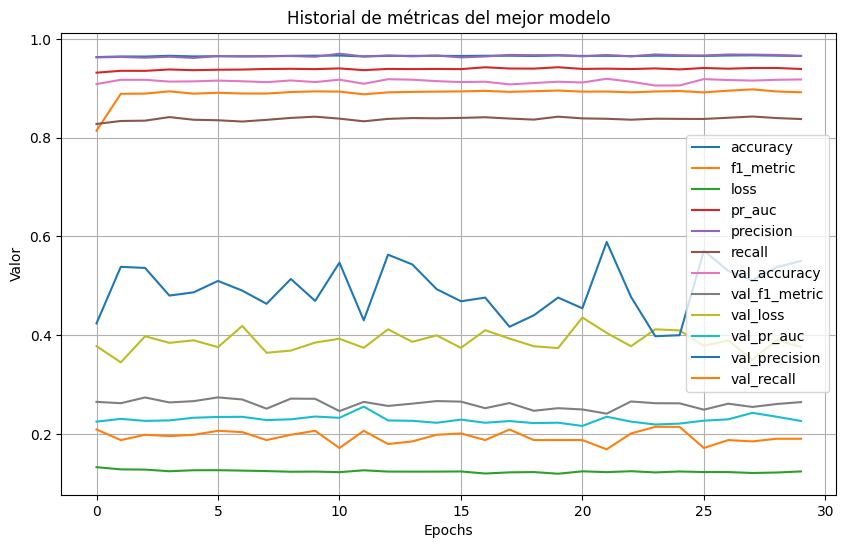

In [51]:
history_dict = best_history.history

plt.figure(figsize=(10,6))

for metric, values in history_dict.items():
    plt.plot(values, label=metric)

plt.xlabel("Epochs")
plt.ylabel("Valor")
plt.title("Historial de métricas del mejor modelo")
plt.legend()
plt.grid(True)
plt.show()

In [52]:
# Evaluar el modelo en los datos de test
results = best_model.evaluate(X_test_final, y_test, batch_size=32, verbose=1)

# Imprimir resultados
for name, value in zip(best_model.metrics_names, results):
    print(f"{name}: {value:.4f}")

343/343 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9138 - f1_metric: 0.0631 - loss: 0.5996 - pr_auc: 0.0997 - precision: 0.3514 - recall: 0.0139
loss: 0.5996
compile_metrics: 0.0997


138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Mejor threshold encontrado: 0.39 con F1: 0.1780
343/343 ━━━━━━━━━━━━━━━━━━━━ 0s 758us/step


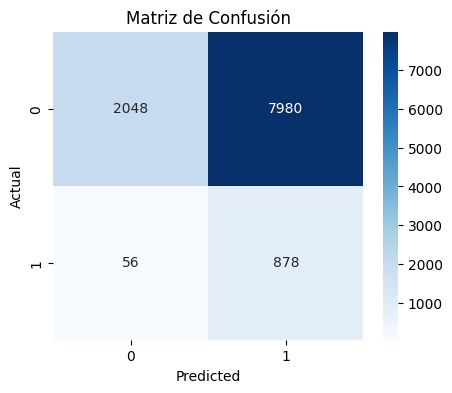

Accuracy: 0.2669

Reporte de clasificación:
              precision    recall  f1-score   support

           0     0.9734    0.2042    0.3376     10028
           1     0.0991    0.9400    0.1793       934

    accuracy                         0.2669     10962
   macro avg     0.5363    0.5721    0.2585     10962
weighted avg     0.8989    0.2669    0.3241     10962



In [53]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1️⃣ Predicciones probabilísticas sobre validación
y_val_prob = best_model.predict(X_val_final, batch_size=32)

# 2️⃣ Encontrar el mejor threshold usando validación
thresholds = np.arange(0.1, 0.9, 0.01)
best_f1 = 0
best_thresh = 0.5

for t in thresholds:
    y_pred_val = (y_val_prob > t).astype(int)
    f1 = f1_score(y_val, y_pred_val)
    if f1 > best_f1:
        best_f1 = f1
        best_thresh = t

print(f"Mejor threshold encontrado: {best_thresh:.2f} con F1: {best_f1:.4f}")

# 3️⃣ Aplicar threshold al test
y_test_prob = best_model.predict(X_test_final, batch_size=32)
y_pred = (y_test_prob > best_thresh).astype(int)

# 4️⃣ Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Matriz de Confusión")
plt.show()

# 5️⃣ Métricas finales
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc:.4f}\n")
print("Reporte de clasificación:")
print(classification_report(y_test, y_pred, digits=4))


## RESULTADOS CON CLUSTERING CENTROIDS (UNDER SAMPLING)

In [54]:
selected_dataset = "CC"  

# Extraer la configuración del dataset seleccionado
config = datasets[selected_dataset]

# Entrenar / tunear
best_hps, best_history_CC = train_model(
    config["X"],
    config["y"],
    X_val_final,
    y_val,
    use_class_weights=config["use_class_weights"]
)

best_model_CC = build_model(best_hps)
best_model_CC.save(f"best_model_{selected_dataset}.keras") 

Trial 90 Complete [00h 00m 08s]
val_f1_metric: 0.1889895498752594

Best val_f1_metric So Far: 0.23299039900302887
Total elapsed time: 00h 11m 35s
Epoch 1/30


/home/lcc_rn_08/.conda/envs/ml_gpu/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 2 variables whereas the saved optimizer has 8 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6214 - f1_metric: 0.4442 - loss: 0.6378 - pr_auc: 0.7065 - precision: 0.6241 - recall: 0.6105 - val_accuracy: 0.6971 - val_f1_metric: 0.2314 - val_loss: 0.6886 - val_pr_auc: 0.2247 - val_precision: 0.1552 - val_recall: 0.5764
Epoch 2/30
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6385 - f1_metric: 0.6269 - loss: 0.6180 - pr_auc: 0.7215 - precision: 0.6478 - recall: 0.6070 - val_accuracy: 0.7006 - val_f1_metric: 0.2304 - val_loss: 0.6856 - val_pr_auc: 0.2228 - val_precision: 0.1549 - val_recall: 0.5657
Epoch 3/30
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6471 - f1_metric: 0.6215 - loss: 0.6084 - pr_auc: 0.7343 - precision: 0.6605 - recall: 0.6055 - val_accuracy: 0.6876 - val_f1_metric: 0.2249 - val_loss: 0.6834 - val_pr_auc: 0.2239 - val_precision: 0.1497 - val_recall: 0.5710
Epoch 4/30
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6513 - f1_metric: 0.6241 - loss: 0.6065 - pr_auc: 0.7378 - precision:

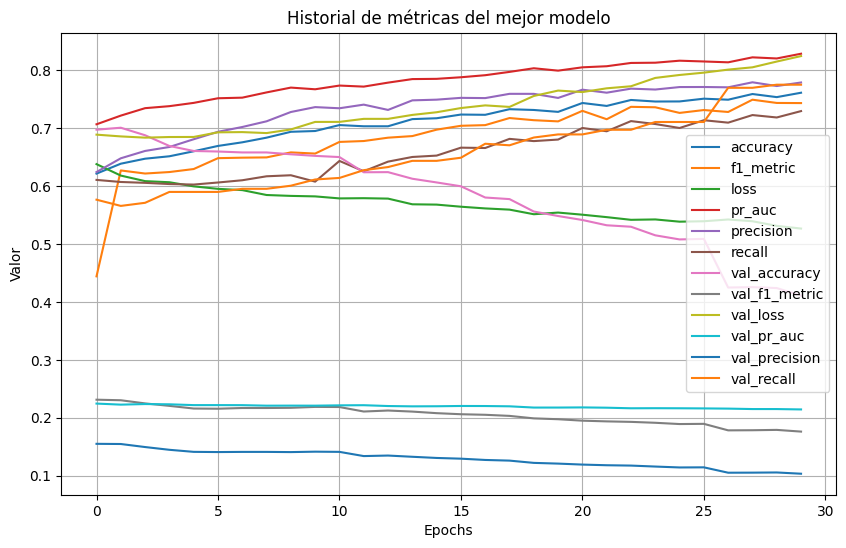

In [55]:
history_dict = best_history_CC.history

plt.figure(figsize=(10,6))

for metric, values in history_dict.items():
    plt.plot(values, label=metric)

plt.xlabel("Epochs")
plt.ylabel("Valor")
plt.title("Historial de métricas del mejor modelo")
plt.legend()
plt.grid(True)
plt.show()



138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step
Mejor threshold encontrado: 0.55 con F1: 0.1802
343/343 ━━━━━━━━━━━━━━━━━━━━ 0s 501us/step


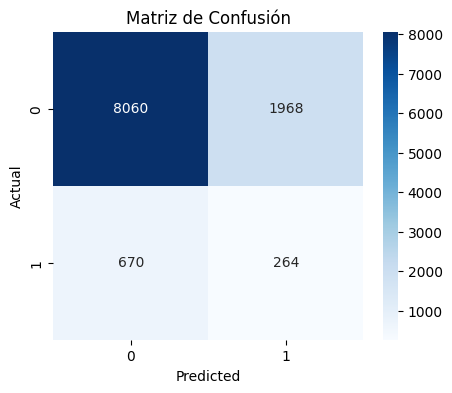

Accuracy: 0.7594

Reporte de clasificación:
              precision    recall  f1-score   support

           0     0.9233    0.8037    0.8594     10028
           1     0.1183    0.2827    0.1668       934

    accuracy                         0.7594     10962
   macro avg     0.5208    0.5432    0.5131     10962
weighted avg     0.8547    0.7594    0.8004     10962



In [56]:
 #1️⃣ Predicciones probabilísticas sobre validación
y_val_prob = best_model_CC.predict(X_val_final, batch_size=32)

# 2️⃣ Encontrar el mejor threshold usando validación
thresholds = np.arange(0.1, 0.9, 0.01)
best_f1 = 0
best_thresh = 0.5

for t in thresholds:
    y_pred_val = (y_val_prob > t).astype(int)
    f1 = f1_score(y_val, y_pred_val)
    if f1 > best_f1:
        best_f1 = f1
        best_thresh = t

print(f"Mejor threshold encontrado: {best_thresh:.2f} con F1: {best_f1:.4f}")

# 3️⃣ Aplicar threshold al test
y_test_prob = best_model_CC.predict(X_test_final, batch_size=32)
y_pred = (y_test_prob > best_thresh).astype(int)

# 4️⃣ Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Matriz de Confusión")
plt.show()

# 5️⃣ Métricas finales
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc:.4f}\n")
print("Reporte de clasificación:")
print(classification_report(y_test, y_pred, digits=4))


# Conclusiones

Ninguno clasifico bien, sospecho que la dificultad está intrínseca en el dataset,  